In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [3]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train/255, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test/255, y_test))
val_ds = test_ds.take(100)


In [5]:
y = [y for x, y in val_ds]

In [6]:
y[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)>

In [7]:
z= np.concatenate([z for z in val_ds], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
z[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [9]:
train_ds.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [10]:
test_ds.element_spec

(TensorSpec(shape=(32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [11]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(x_train)


In [13]:
train_len = len(x_train)

In [14]:
image_size = (32,32,3)
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / train_len

model_vi = tf.keras.Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(10, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [15]:
epochs=100
# from keras import backend as K
# K.set_value(model_vi.optimizer.learning_rate, 0.005)
model_vi.fit(train_dataset,epochs=epochs,batch_size=32,validation_data=test_dataset)
# model_vi.save('BCNN_cf10.h5') 

Epoch 1/100
782/782 [==============================] - 157s 196ms/step - loss: 7.3643 - accuracy: 0.2651 - val_loss: 6.6234 - val_accuracy: 0.3557
Epoch 2/100
782/782 [==============================] - 157s 200ms/step - loss: 6.1298 - accuracy: 0.4050 - val_loss: 5.7195 - val_accuracy: 0.4306
Epoch 3/100
782/782 [==============================] - 160s 204ms/step - loss: 5.4035 - accuracy: 0.4531 - val_loss: 5.1232 - val_accuracy: 0.4709
Epoch 4/100
782/782 [==============================] - 161s 206ms/step - loss: 4.9047 - accuracy: 0.4791 - val_loss: 4.7179 - val_accuracy: 0.4830
Epoch 5/100
782/782 [==============================] - 160s 204ms/step - loss: 4.5471 - accuracy: 0.5011 - val_loss: 4.4189 - val_accuracy: 0.5006
Epoch 6/100
782/782 [==============================] - 159s 203ms/step - loss: 4.2697 - accuracy: 0.5183 - val_loss: 4.1938 - val_accuracy: 0.5114
Epoch 7/100
782/782 [==============================] - 160s 204ms/step - loss: 4.0522 - accuracy: 0.5356 - val_loss: 4

In [41]:

labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])

pred_vi=np.zeros((len(x_test),10))
pred_max_p_vi=np.zeros((len(x_test)))
pred_std_vi=np.zeros((len(x_test)))
entropy_vi = np.zeros((len(x_test)))

for i in tqdm(range(0,len(x_test))):
  multi_img=np.tile(x_test[i]/255,(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.mean(preds,axis=0)#mean over n runs of every proba class
  pred_max_p_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
  pred_std_vi[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_vi[i] = -np.sum( pred_vi[i] * np.log2(pred_vi[i] + 1E-14)) #Numerical Stability
pred_labels_vi=np.array([labels[np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
pred_vi_mean_max_p=np.array([pred_vi[i][np.argmax(pred_vi[i])] for i in range(0,len(pred_vi))])
nll_vi=-np.log(pred_vi_mean_max_p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [42]:
true_labels=np.array([labels[np.argmax(y_test[i])] for i in range(0,len(y_test))])
test_acc_all_vi=np.average(true_labels==pred_labels_vi)
test_acc_all_vi

0.699

In [43]:
def plot_hists(dist, title, xlabel, xlim=None):
    plt.hist(dist[range(0,len(x_test))],bins=30, density=True,alpha = 0.7)
    # plt.hist(dist[known_idx],bins=30,  density=True,alpha = 0.7)
    plt.title(title)
    # plt.legend(['unknown','known'])
    plt.xlabel(xlabel)
    if xlim != None:
        plt.xlim(xlim)

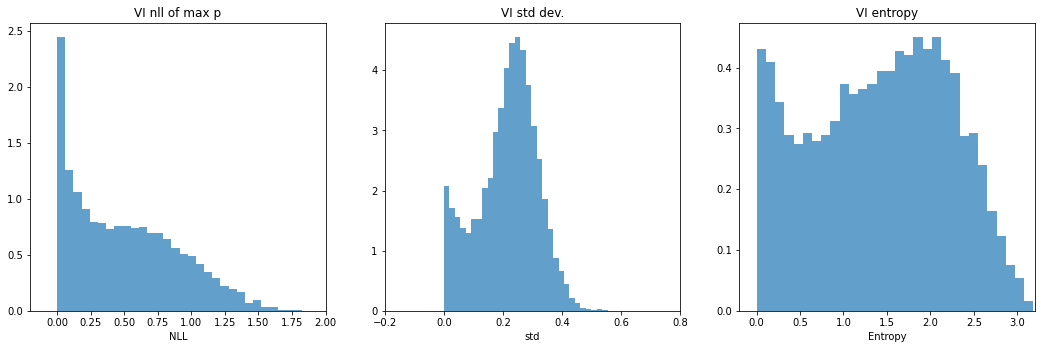

In [44]:
plt.figure(figsize=(18,18))
plt.subplot(3,3,4)
plot_hists(nll_vi, "VI nll of max p", "NLL", [-0.2,2])
plt.subplot(3,3,5)
plot_hists(pred_std_vi, "VI std dev.", "std", [-0.2,0.8])
plt.subplot(3,3,6)
plot_hists(entropy_vi, "VI entropy", "Entropy", [-0.2,3.2])

In [23]:
  multi_img=np.tile(x_test[0],(1,1,1,1))


In [45]:
test_in = x_test[0]/255

test_in.shape = (1,) + x_test[0].shape 

In [46]:
test_in.shape

(1, 32, 32, 3)

In [47]:
preds_1=model_vi.predict(test_in)

In [48]:
preds_1

array([[5.3926726e-04, 3.7848260e-04, 7.6155523e-03, 5.1037204e-01,
        4.1819359e-03, 4.5107877e-01, 1.1861167e-02, 1.1451225e-02,
        1.9883574e-03, 5.3323217e-04]], dtype=float32)

In [49]:
x=np.zeros(shape=(100,10))
for i in range(100):
  x[i] = model_vi.predict(test_in)


In [51]:
x

array([[2.20305682e-03, 1.48566358e-03, 7.19584245e-03, 5.34177244e-01,
        8.90203752e-03, 3.61849010e-01, 3.13240923e-02, 1.18124066e-02,
        3.72299887e-02, 3.82059696e-03],
       [3.72865907e-04, 1.64219178e-04, 2.85759196e-03, 4.98290926e-01,
        1.10861601e-03, 4.77194428e-01, 7.93695729e-03, 8.57887324e-03,
        3.34845646e-03, 1.47087674e-04],
       [9.99531243e-04, 7.15588743e-04, 3.48326820e-03, 4.67317700e-01,
        1.50014076e-03, 4.98600304e-01, 1.15173990e-02, 1.30487727e-02,
        2.34506000e-03, 4.72262240e-04],
       [1.55588810e-03, 1.19505590e-03, 3.13130650e-03, 4.61456537e-01,
        7.52171408e-03, 2.76026458e-01, 7.77968243e-02, 4.68490794e-02,
        1.23211518e-01, 1.25555776e-03],
       [1.28600601e-04, 1.90547202e-04, 2.33344571e-03, 6.36125207e-01,
        7.14276161e-04, 3.46243232e-01, 1.15994317e-02, 1.85773557e-03,
        2.32742939e-04, 5.74826030e-04],
       [1.48850051e-03, 4.09156579e-04, 7.33452849e-03, 5.49850762e-01,
   

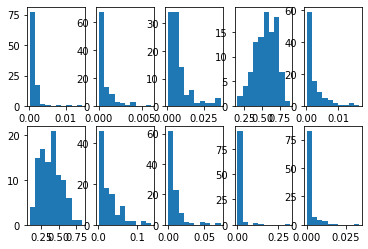

In [52]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.hist(x[:,i])

In [58]:
x.mean(axis=0)

array([0.00130145, 0.00078639, 0.00801943, 0.54989553, 0.00270165,
       0.38523097, 0.02748659, 0.00869002, 0.01361067, 0.00227728])

In [33]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [63]:
(x_train_b, y_train_b), (x_test_b, y_test_b) = tf.keras.datasets.cifar10.load_data()

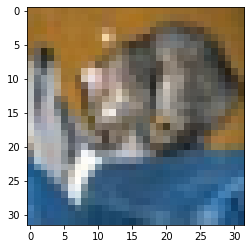

In [64]:
plt.imshow(x_test_b[0])

In [80]:
labels[y_test_b[0].tolist()[0]]

'cat'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0, 0.5, 'P(class)')

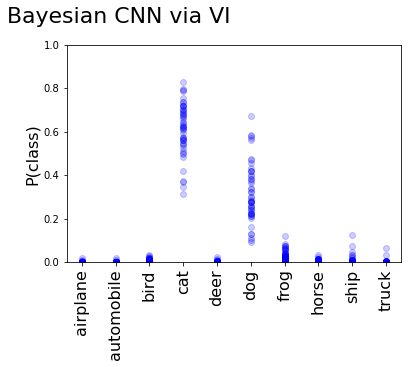

In [81]:
# plt.subplot(4,3,7)
# plt.axis('off')
plt.text(1.1,1.1, "Bayesian CNN via VI",fontsize=22,horizontalalignment='center')
plt.subplot(1,1,1)
for i in range(0,50):
  plt.scatter(range(0,10),model_vi.predict(test_in),c="blue",alpha=0.2)
# plt.xticks(range(0,10),labels=np.repeat(" ",10))
plt.xticks(range(0,10),labels=labels,fontsize=16)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.ylabel("P(class)",fontsize=16)


As you can see, the picture was predicted as a cat which is the same as the true label of the picture. However, we see more detail of the uncertain levels of the Bayesian prediction. There are some uncertainty that it may also be  a dog, frog, ship, truck, airplane, automobile, bird, deer. However, the probability to be cat is significantly higher than others.